<font><div><center> 
# Failure during Observation 1 of Global Alignment
</center></div></font> 

This notebook is for the case that guiding fails during Global Alignment (1 or 2) observation 1 due to a failure of ID, ACQ, or TRK when trying for the 2nd or 3rd to engage closed-loop guiding. 

This notebook currently has this set up with GA 1 and GA 2 data from MIRAGE. If you need to use this for commissioning, save a copy of this notebook and replace the indicated options in the cell below with the necessary information.

In [258]:
# Import necessary packages

# Standard Library
from glob import glob
import os
from io import StringIO
from functools import reduce

# Third Party Packages
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

%matplotlib inline

# Guiding Failure in OTE-07 Observation 1

* [Functions](#Functions-used-below)
* [Parameters to change](#Parameters-to-change)



## Functions used below

In [244]:
# Find the indices of the object in the bright object list that most closely matches the commanded values

def distance(y1, x1, y2, x2):
    """Find the combined distances between x and y points"""
    return np.abs((y1-y2)+(x1-x2))


def find_bright_obj(y, x, bright_obj_df):
    """Find the index in the bright object list that has the minimum distance to a point"""
    index = bright_object_df.apply(
        lambda row: distance(y, x, row['FPA Row (pixels)'], row['FPA Column (pixels)']), 
        axis=1)
    return index.idxmin()


def match_bright_obj_to_command(commanded, bright_obj_df):
    """For each x, y position in the commanded list, find the index of the PSF in the bright object list
    that is the closest. 
    """
    matching_indices = commanded.apply(
                                        lambda row: find_bright_obj(row['y'], row['x'], bright_obj_df), 
                                        axis=1).values
    return matching_indices


In [136]:
# Analysis

def compare_commanded_vs_measured(commanded_df, measured_df, commanded_index, measured_index):
    """
    Both data frames are expected to have the same order and number. The measured_df is expected to come from the 
    bright object list
    Index which index in the list to use: GS = 0, REF1 = 1, REF2 = 2
    """
    # Grab appropriate row in each data frame
    commanded = commanded_df.loc[[commanded_index]]
    measured = measured_df.loc[[measured_index]]
    
    # Find the floor of the *3x3 counts* that we are allowing
    commanded_counts = commanded['id counts'].values[0]
    commanded_threshold = commanded['id threshold'].values[0]
    minimum_counts = commanded_counts - commanded_threshold

    # Grab the 3x3 count sum that was measured for the same object
    measured_counts = measured[' FPA Count Sum (counts)'].values[0]
    
    # Compare
    if measured_counts < minimum_counts:
        print('The measured number of counts is below the commanded - threshold value.')
        new_threshold = (commanded_counts - measured_counts)/commanded_counts
        print(f' Recommended threshold = {new_threshold}')
    else: 
        print('The measured number of counts is equal to or greater than the commanded '
              + f'- threshold value by {np.round(measured_counts - minimum_counts)} counts.')
        new_threshold = threshold # None
        
    return new_threshold


def compare_config(commanded_df, measured_df, matching_indices):
    """
    Compare the commanded counts and threshold with the measured counts
    """
    recommended_thresholds = []
    order = ['GS', 'REF1', 'REF2']
    for commanded_index, measured_index, object in zip(np.arange(3), matching_indices, order):
        print(object)
        recommended_thresholds.append(compare_commanded_vs_measured(commanded_df, measured_df, 
                                                                    commanded_index, measured_index))
        
    if all(thresh == threshold for thresh in recommended_thresholds):
        print(f"\tNo new threshold needed. Config should have passed ID with threshold of {threshold}")
    else:
        recommended_new_threshold = max(recommended_thresholds)
        print(f"\tRecommended new threshold = {recommended_new_threshold}")

<font color='Tomato'> <div style='background-color: rgba(255, 99, 71, 0.3)'><center> 
##    
## You will not be able to run this notebook without changing the below parameters
##    
</center></div></font>

<font><div><center> 
## Parameters to change 
</center></div></font>  

To run this notebook for your data set where guiding has failed, you will need to change the parameters in the call below to match your data. This notebook is set up such that this is the ONLY cell you should have to update. 

In [126]:
# Values that have been set in MAGIC

threshold = .6  # Value in MAGIC to set the count rate threshold
guider = 1  # FGS dectector that will be used for observation 1 -- this will always be 1 for OTE-07/GA1
nrc_detector = 'A3'  # NIRCam detector used for NIRCam observations

In [138]:
# Information about the command used to for the override

# Out Directory passed intp MAGIC
commanded_out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/' 

# Root passed into MAGIC
root_psuedo_fgs = 'for_ote07_obs1'

# Number associated with the config used for the commands. Expecting up to 3
config_numbers = [1, 2, 3]

In [59]:
# The location of data from the observatory
failed_observation_products = '/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/data_products'

# For each step where you have the data, provide the filename of the images in the above directory
# It's likely that the below filenames are already correct, but be sure to check them!
# If you do not have all of this data, you can delete the file name or comment out the line

#  --Before the first mirror move--
nrc_track_1_filename = 'jw01141001001_02101_00001_nrca3_cal.fits'

#  --After the first mirror move--
nrc_coarse_1_filename = 'jw01141001001_02101_00002_nrca3_cal.fits'
fgs_coarse_1_filename = 'jw01141001001_03101_00001_g1_cal.fits'
nrc_track_2_filename = 'jw01141001001_05101_00001_nrca3_cal.fits'

#  --After the first mirror move--
nrc_coarse_2_filename = 'jw01141001001_05101_00002_nrca3_cal.fits'
fgs_coarse_2_filename = 'jw01141001001_06101_00001_g1_cal.fits'


In [25]:
# The bright object list that will come out of running the failed ID strips through DHAS
bright_object_list_config1 = glob(os.path.join(failed_observation_products, 'idSim_cfg_default_*.bobj'))[0]
print(bright_object_list_config1)

/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/data_products/idSim_cfg_default_20210713_164854.bobj


In [26]:
# CAR information 
program_id = 1141 # GA1; use 1151 for GA2
observation = 1

<font color='DodgerBlue'> <div style='background-color: rgba(30, 144, 255, 0.3)'><center> 
##    
## Run the following cells without changing them
##    
</center></div></font>

<font><div><center> 
### Set up mapping between segment names and MAGIC's labelling 
</center></div></font>  

**Guider 1**

<table><tr><td><img src="../g1_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

In [27]:
# Do not change this cell

# MAGIC segment labels to segment naming map
segment_map_g1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}

**Guider 2**

<table><tr><td><img src="../g2_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

In [29]:
# Do not change this cell

# MAGIC segment labels to segment naming map
segment_map_g2 = {"A":"B1-7", "B":"C6-18", "C":"C1-8", "D":"B6-17",
                  "E":"A1-1", "F":"B2-9", "G":"A6-6", "H":"A2-2", 
                  "I":"C5-16", "J":"C2-10", "K":"A5-5", "L":"A3-3", 
                  "M":"B5-15", "N":"A4-4", "O":"B3-11", "P":"C4-14", 
                  "Q":"C3-12", "R":"B4-13"}

In [30]:
# Do not change these variables
if guider==1:
    segment_map = segment_map_g1
elif guider==2:
    segment_map = segment_map_g2
else:
    raise ValueError('There are only two guiders. Please provide "1" or "2" for the guider variable')

<font><div><center> 
# Examine the data from the failed observation
</center></div></font>  

All of the data below is in the SCI frame which is different from the frame the the MAGIC products are in. The plots below are informative *only* and are not meant to be used to extrapolate information.

In [142]:
# Open the images
try: 
    nircam_track_1 = fits.getdata(os.path.join(failed_observation_products, nrc_track_1_filename))

    nircam_coarse_1 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_1_filename))
    fgs_coarse_1 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_1_filename))
    try:  
        nircam_track_2 = fits.getdata(os.path.join(failed_observation_products, nrc_track_2_filename))
        mirror_move_2 = True
    except (FileNotFoundError, IsADirectoryError):
        print('Observation failed to get into track after first mirror move')
        mirror_move_2 = False

    if mirror_move_2:
        nircam_coarse_2 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_2_filename))
        fgs_coarse_2 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_2_filename))
except (FileNotFoundError, IsADirectoryError):
    print('Observation failed to get into track on the first attempt. Only guider data will be available.')

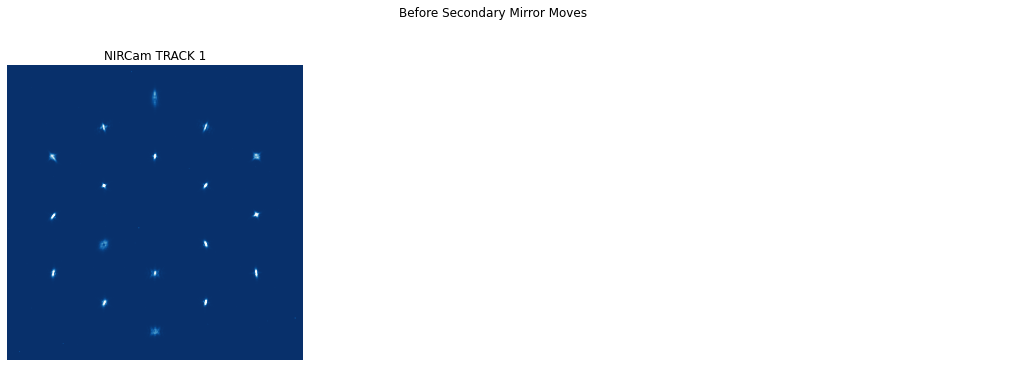

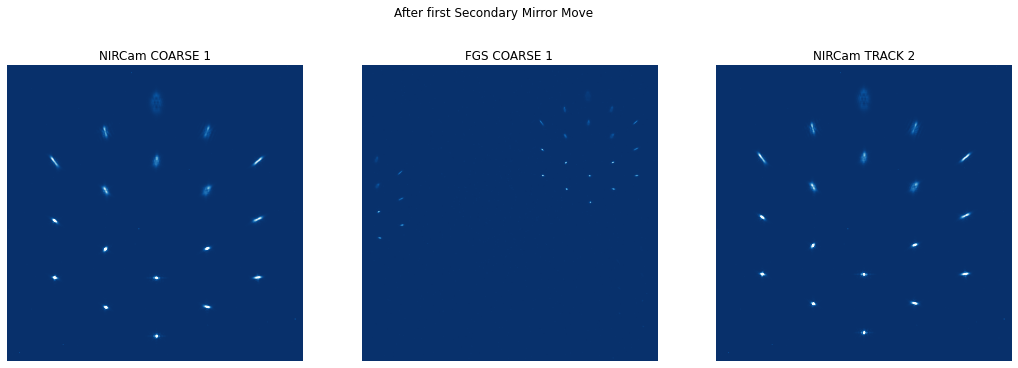

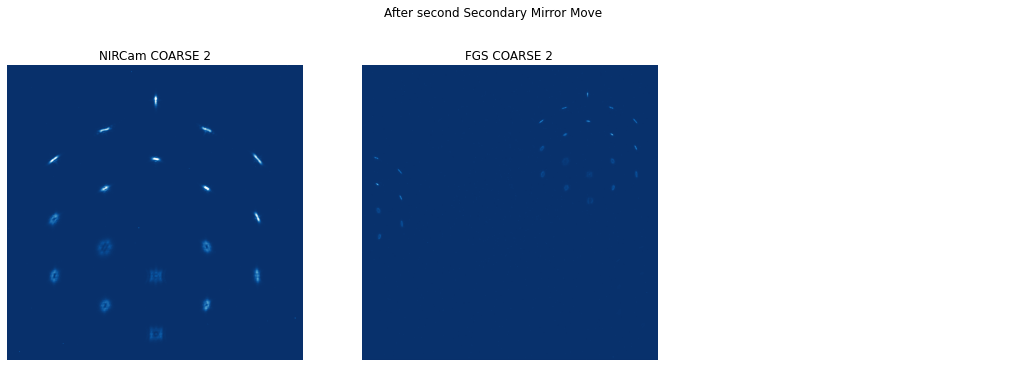

In [143]:
# Plot images
try:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(nircam_track_1, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
    ax[0].set_title('NIRCam TRACK 1')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    fig.suptitle("Before Secondary Mirror Moves")
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(nircam_coarse_1, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
    ax[0].set_title('NIRCam COARSE 1')
    ax[0].axis('off')
    ax[1].imshow(fgs_coarse_1, cmap='Blues_r', vmin=0, vmax=50, origin='lower')
    ax[1].set_title('FGS COARSE 1')
    ax[1].axis('off')
    fig.suptitle("After first Secondary Mirror Move")

    try:
        ax[2].imshow(nircam_track_2, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
        ax[2].set_title('NIRCam TRACK 2')
        ax[2].axis('off')
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(nircam_coarse_2, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
        ax[0].set_title('NIRCam COARSE 2')
        ax[0].axis('off')
        ax[1].imshow(fgs_coarse_2, cmap='Blues_r', vmin=0, vmax=50, origin='lower')
        ax[1].set_title('FGS COARSE 2')
        ax[1].axis('off')
        ax[2].axis('off')
        fig.suptitle("After second Secondary Mirror Move")
    except NameError:
        plt.show()
except NameError:
    print('No full frame data NIRCam or FGS to show')

<font><div><center> 
#  Compare the Guiding Selections with the Bright Object List
</center></div></font>
    
Take the ID strips for a failed run (from sky/MAST) and run them through the DAHS to get bright object list Compare the bright object list to the command

## Bright Object List

In [80]:
# Print the bright object list filename
bright_object_list

'/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/out/ote07_obs1_fgs_coarse1/guiding_config_1/dhas_shifted/idSim_cfg_default_20210713_164854.bobj'

In [81]:
# Read the bright object list into a table (Data Frame)
bright_object_df = pd.read_csv(bright_object_list)

# Display the table
bright_object_df

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,27,1,1508,1118,1194,7792
1,1,30,1,1668,1208,1016,7289
2,2,21,2,1183,1116,997,7404
3,3,27,2,1502,1301,1180,6853
4,4,24,1,1343,1209,1109,6316
5,5,30,2,1674,1028,883,6039
6,6,21,1,1177,1302,839,5667
7,7,24,1,1340,1392,750,4678
8,8,18,2,1018,1208,595,4116
9,9,30,2,1682,836,388,2440


In the above dataframe, the 'FPA Column (pixels)' column corresponds to 'x', the 'FPA Row (pixels)' column corresponds to 'y', and the 'FPA Count Sum (counts)' is our 3x3 count rate that is labelled 'countrate' in the guiding selections file.

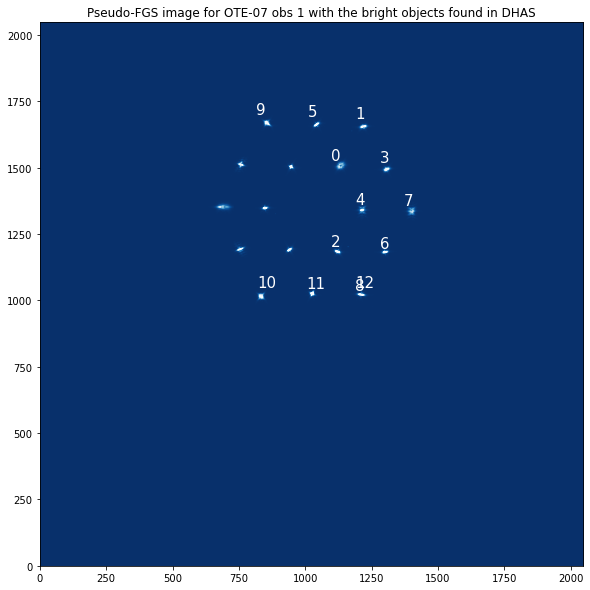

In [148]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')

for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white', fontsize=15)

plt.title('Pseudo-FGS image for OTE-07 obs 1 with the bright objects found in DHAS')
plt.show()

### Guiding Selections for Guiding Configuration 1

In [145]:
# Guiding selections file
# The first row is the guide star, subsequent rows are reference stars. Order of ref stars doesn't matter.
commanded = pd.read_csv(os.path.join(out_dir, 'out', root_psuedo_fgs, f'guiding_config_{config_numbers[0]}',
                        f'shifted_guiding_selections_{root_psuedo_fgs}_G{guider}_config{config_numbers[0]}.txt'),
                        skiprows=1, delimiter=' ', names=['y', 'x', 'countrate'])

# Add the count rate threshold to the table
thresholds = threshold * commanded['countrate'].values

commanded['threshold'] = thresholds

# Display the table
commanded

,y,x,countrate,threshold
0,1024.5,1024.5,30726.0,18435.6
1,1654.5,1216.5,26162.0,15697.2
2,1667.5,853.5,15204.0,9122.4


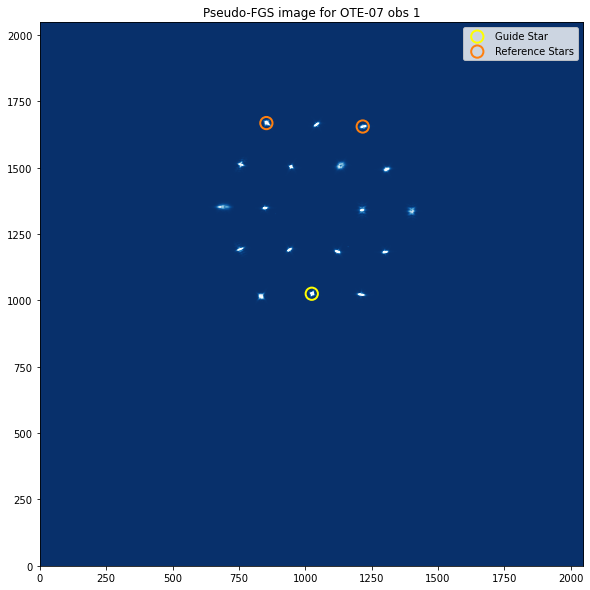

In [79]:
# Plot our Psuedo FGS image with the guiding selections highlighted
image_filename = os.path.join(out_dir, 'out', root_psuedo_fgs, 'guiding_config_1', 'FGS_imgs', 
                                   f'shifted_{root_psuedo_fgs}_G1_config1.fits')

# Load in the image
psuedo_fgs = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=150, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1:], commanded['y'].values[1:], s=150, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Stars")
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

TODO: Use the mapping to tell us which segments this is?

### Update the Commanded dataframe with the counts and threshold during ID - for comparison with the bright objects

In [75]:
# Frame time for ID
t_id = 0.3406 

In [124]:
# Include counts for ID
commanded_count_rates = commanded['countrate'].values
commanded_counts_id = commanded_count_rates*t_id

commanded['id counts'] = commanded_counts_id

# Include thresholds for ID
commanded_thresholds = commanded['thresholds'].values
commanded_threshold_id = com_thresholds*t_id

commanded['id threshold'] = com_threshold_id

In [125]:
commanded

,y,x,countrate,thresholds,id counts,id threshold
0,1024.5,1024.5,30726.0,27653.4,10465.2756,9418.74804
1,1654.5,1216.5,26162.0,23545.8,8910.7772,8019.69948
2,1667.5,853.5,15204.0,13683.6,5178.4824,4660.63416


## Cross-match the command with the bright object list 

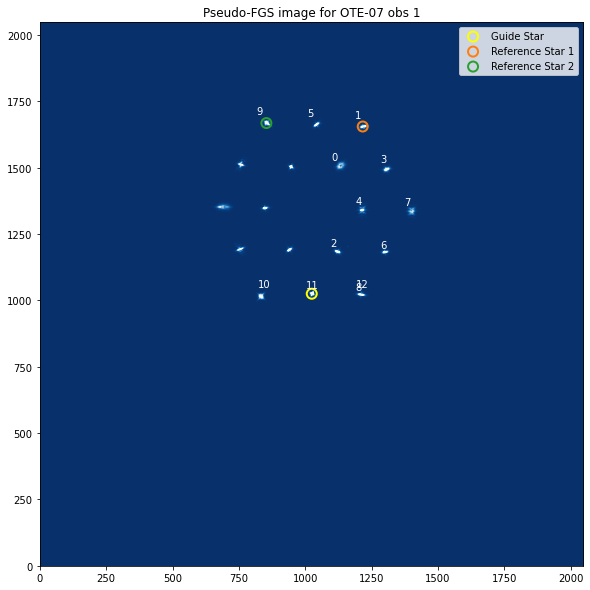

In [82]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=100, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1], commanded['y'].values[1], s=100, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Star 1")
plt.scatter(commanded['x'].values[2], commanded['y'].values[2], s=100, facecolors='none',  edgecolors='C2',
            linewidths=2.0, label="Reference Star 2")
for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

<font color='SlateBlue'> <div>

### CHECK: Did the commanded objects even make it on the bright object list??    
 
</div></font>

If they did, then you can run the next two cells. 

If not, then you know why it failed. Either go back and recreated your command with wider threshold value, OR make new selections. What you choose will depend on at what point in the observation you failed, and if you have to move through all the mirror moves again. 

In [245]:
matching_indices = match_bright_obj_to_command(commanded, bright_obj_df)
print('Guide Star: {}\nRef 1: {}\nRef 2: {}\n'.format(*matching_indices))

NameError: name 'bright_obj_df' is not defined

In [107]:
# If the above algorithm doesn't choose the correct indicies (based on the plot above), you can overwrite that 
#  array below, uncomment the line, and run the cell.
# matching_indices = [11, 1, 9]

In [109]:
selected_bright_object_df = bright_object_df.loc[matching_indices]

selected_bright_object_df = selected_bright_object_df[['FPA Row (pixels)', 'FPA Column (pixels)', 
                                                       ' FPA Count Sum (counts)']]

selected_bright_object_df

,FPA Row (pixels),FPA Column (pixels),FPA Count Sum (counts)
11,1025,1024,2059
1,1668,1208,7289
9,1682,836,2440


## Analysis

[Here is where you can analysis what you have seen in the comaparison above. I will write my analysis for the above example here, you might wish to include your analysis in your notebook so you can pass that information off to the relavent teams]

### Config 1 

#### Guide star 

In [137]:
compare_config(commanded, selected_bright_object_df, matching_indices)

GS
1046.5275600000004
2059
The measured number of counts is equal to or greater than the commanded - threshold value by 1012.0 counts.
REF1
891.0777200000002
7289
The measured number of counts is equal to or greater than the commanded - threshold value by 6398.0 counts.
REF2
517.8482399999994
2440
The measured number of counts is equal to or greater than the commanded - threshold value by 1922.0 counts.
	No new threshold needed. Config should have passed ID with threshold of 0.6


## Making a new override command 

TODO: determine what threshold is necessary to pass

Make clear that the failure is ...?

Options update the thresholds on the same commands, or pick new commands

Use the same commands if the new recommended threshold is less than 100%. 
Use a new commands if the recommended threshold is over 100%

# Playground 

In [149]:
data_location = '/Users/kbrooks/git_repos/jwst-magic-fork/out/LRE5/rehearsal/out/'
command_loc = 'for_ote07_obs1'
attempt1_loc = 'ote07_obs1_attempt1'
attempt2_loc = 'ote07_obs1_attempt2'
attempt3_loc = 'ote07_obs1_attempt3'

## Compare the unshifted all found PSFs for each 
This will only be an option if you have run all images through MAGIC

In [150]:
command_file = glob(os.path.join(data_location, command_loc, 'unshifted_all_found_psfs*.txt'))[0]
attempt1_file = glob(os.path.join(data_location, attempt1_loc, 'unshifted_all_found_psfs*.txt'))[0]
attempt2_file = glob(os.path.join(data_location, attempt2_loc, 'unshifted_all_found_psfs*.txt'))[0]
attempt3_file = glob(os.path.join(data_location, attempt3_loc, 'unshifted_all_found_psfs*.txt'))[0]

In [165]:
command = pd.read_csv(command_file, skiprows=1, delimiter=' ', usecols=[0, 3], names=['Label', 'Count Rate 1'])
attempt1 = pd.read_csv(attempt1_file, skiprows=1, delimiter=' ', usecols=[0, 3], names=['Label', 'Count Rate 2'])
attempt2 = pd.read_csv(attempt2_file, skiprows=1, delimiter=' ', usecols=[0, 3], names=['Label', 'Count Rate 3'])
attempt3 = pd.read_csv(attempt3_file, skiprows=1, delimiter=' ', usecols=[0, 3], names=['Label', 'Count Rate 4'])

In [227]:
dfs = [command, attempt1, attempt2, attempt3]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Label'), dfs)

In [229]:
seg_list = [segment_map_g1[label] for label in df_final['Label'].values]

In [230]:
df_final.insert(loc=1, column='Segment', value=seg_list)

In [232]:
cr1 = df_final['Count Rate 1']
cr2 = df_final['Count Rate 2']
cr3 = df_final['Count Rate 3']
cr4 = df_final['Count Rate 4']

percent_change_1 = np.round((cr1-cr2)/cr1*100., 2)
df_final.insert(loc=4, column='% change 1', value=percent_change_1)
percent_change_2 = np.round((cr1-cr3)/cr1*100., 2)
df_final.insert(loc=6, column='% change 2', value=percent_change_2)
percent_change_3 = np.round((cr1-cr4)/cr1*100., 2)
df_final.insert(loc=8, column='% change 3', value=percent_change_3)

In [233]:
df_final

,Label,Segment,Count Rate 1,Count Rate 2,% change 1,Count Rate 3,% change 2,Count Rate 4,% change 3
0,F,B3-11,33700.0,33717.0,-0.05,77238.0,-129.19,54592.0,-61.99
1,O,B2-9,73597.0,73633.0,-0.05,109626.0,-48.95,6907.0,90.62
2,J,C2-10,79585.0,79358.0,0.29,68891.0,13.44,45379.0,42.98
3,Q,C1-8,127918.0,128438.0,-0.41,141639.0,-10.73,11093.0,91.33
4,L,A2-2,117827.0,118280.0,-0.38,197207.0,-67.37,11029.0,90.64
5,H,A3-3,126254.0,126536.0,-0.22,15649.0,87.61,78494.0,37.83
6,C,C3-12,59064.0,59252.0,-0.32,12387.0,79.03,33414.0,43.43
7,R,B1-7,23403.0,23401.0,0.01,268454.0,-1047.09,1782.0,92.39
8,N,A1-1,69861.0,70140.0,-0.40,251363.0,-259.80,8581.0,87.72
9,E,A4-4,121658.0,120730.0,0.76,14454.0,88.12,56819.0,53.30


In [234]:
outer_df = df_final.loc[[0, 1, 2, 3, 6, 7, 10, 11, 14, 15, 16, 17]]

outer_df

,Label,Segment,Count Rate 1,Count Rate 2,% change 1,Count Rate 3,% change 2,Count Rate 4,% change 3
0,F,B3-11,33700.0,33717.0,-0.05,77238.0,-129.19,54592.0,-61.99
1,O,B2-9,73597.0,73633.0,-0.05,109626.0,-48.95,6907.0,90.62
2,J,C2-10,79585.0,79358.0,0.29,68891.0,13.44,45379.0,42.98
3,Q,C1-8,127918.0,128438.0,-0.41,141639.0,-10.73,11093.0,91.33
6,C,C3-12,59064.0,59252.0,-0.32,12387.0,79.03,33414.0,43.43
7,R,B1-7,23403.0,23401.0,0.01,268454.0,-1047.09,1782.0,92.39
10,A,B4-13,20623.0,20704.0,-0.39,3557.0,82.75,100535.0,-387.49
11,P,C6-18,83313.0,83387.0,-0.09,311600.0,-274.01,8547.0,89.74
14,B,C4-14,50044.0,50230.0,-0.37,22408.0,55.22,44520.0,11.04
15,M,B6-17,84046.0,83760.0,0.34,207047.0,-146.35,9060.0,89.22


<table><tr><td><img src="../g1_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

## Commanded vs all bright obj lists

Use config 1 for each to ensure that we are looking at the same-ish locations

In [242]:
command_config1_filename = glob(os.path.join(data_location, attempt1_loc, 'guiding_config_1', 
                                             'shifted_all_found_psfs*config1.txt'))[0]
command_full = pd.read_csv(command_file, skiprows=1, delimiter=' ', names=['Label', 'y', 'x', 'Count Rate 1'])
command_full

,Label,y,x,Count Rate 1
0,F,686.0,822.0,33700.0
1,O,691.0,1208.0,73597.0
2,J,695.0,1019.0,79585.0
3,Q,854.0,1300.0,127918.0
4,L,856.0,1116.0,117827.0
5,H,864.0,931.0,126254.0
6,C,866.0,742.0,59064.0
7,R,1011.0,1402.0,23403.0
8,N,1015.0,1210.0,69861.0
9,E,1023.0,837.0,121658.0


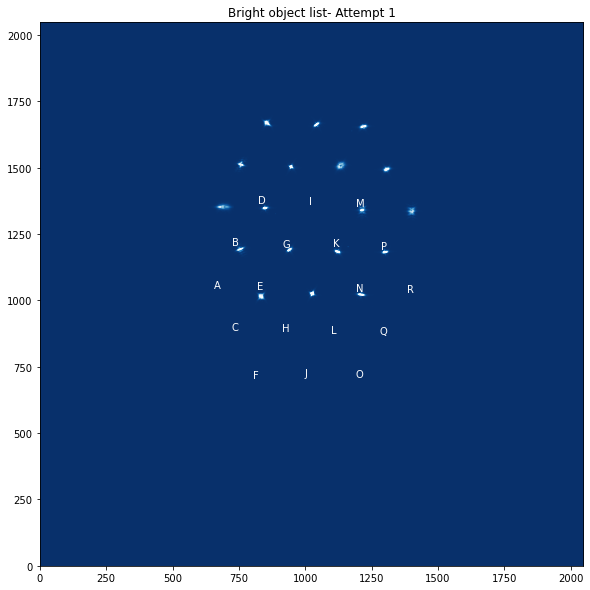

In [250]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
for (column, row, label) in zip(command_full['x'].values, 
                                command_full['y'].values,
                                command_full['Label'].values):
    plt.annotate(label, (column, row), (column-20, row+20), color='white')

plt.title('Bright object list- Attempt 1')
plt.show()

In [240]:
bobj_attempt1_filename = glob(os.path.join(data_location, attempt1_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
print(bobj_attempt1_filename)
bobj_attempt1 = pd.read_csv(bobj_attempt1_filename)

bobj_attempt2_filename = glob(os.path.join(data_location, attempt2_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
print(bobj_attempt2_filename)
bobj_attempt2 = pd.read_csv(bobj_attempt2_filename)


bobj_attempt3_filename = glob(os.path.join(data_location, attempt3_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
print(bobj_attempt3_filename)
bobj_attempt3 = pd.read_csv(bobj_attempt3_filename)

/Users/kbrooks/git_repos/jwst-magic-fork/out/LRE5/rehearsal/out/ote07_obs1_attempt1/guiding_config_1/dhas_shifted/idSim_cfg_default_20210722_153746.bobj
/Users/kbrooks/git_repos/jwst-magic-fork/out/LRE5/rehearsal/out/ote07_obs1_attempt2/guiding_config_1/dhas_shifted/idSim_cfg_default_20210722_154338.bobj
/Users/kbrooks/git_repos/jwst-magic-fork/out/LRE5/rehearsal/out/ote07_obs1_attempt3/guiding_config_1/dhas_shifted/idSim_cfg_default_20210722_154836.bobj


In [247]:
# match bobj1 with command
matching_indices = match_bright_obj_to_command(command_full, bobj_attempt1)

matching_indices

array([10, 10, 10,  8, 11, 10, 10,  6,  8, 10, 10,  6, 11,  2, 10,  4,  2,
        8])

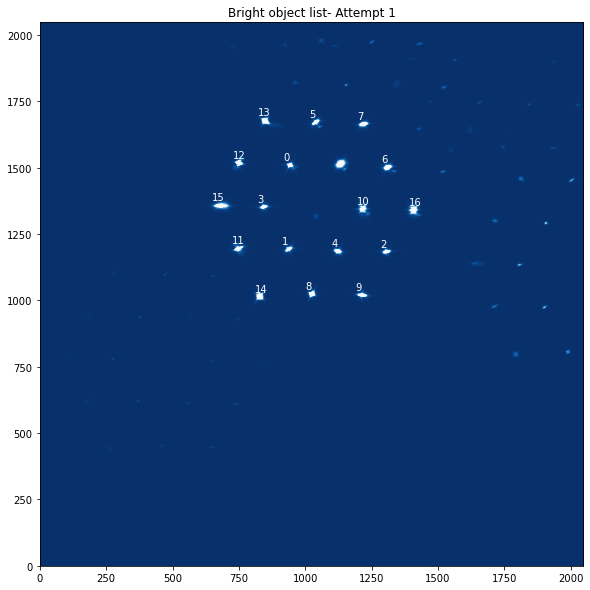

In [254]:
# Plot it
data_location = '/Users/kbrooks/git_repos/jwst-magic-fork/out/LRE5/rehearsal/out/'
attempt1_loc = 'ote07_obs1_attempt1'

bobj_attempt1_filename = glob(os.path.join(data_location, attempt1_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
shifted_psuedo_fgs_filename = glob(os.path.join(data_location, attempt1_loc, 'guiding_config_1', 'FGS_imgs',
                                  'shifted*_config1.fits'))[0]
shifted_psuedo_fgs = fits.getdata(shifted_psuedo_fgs_filename)

plt.figure(figsize=(12, 10))
plt.imshow(shifted_psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
for i, (column, row) in enumerate(zip(bobj_attempt1['FPA Column (pixels)'].values, 
                                      bobj_attempt1['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')

plt.title('Bright object list- Attempt 1')
plt.show()

In [241]:
bobj_attempt1

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,27,2,1508,939,7330,59055
1,1,21,2,1191,933,6195,49007
2,2,21,2,1182,1303,6208,48337
3,3,24,1,1351,840,5701,46638
4,4,21,1,1184,1119,5473,43775
5,5,30,1,1670,1036,4786,38200
6,6,27,1,1500,1307,3883,31571
7,7,30,1,1663,1215,3797,29118
8,8,18,1,1023,1022,3507,28846
9,9,18,2,1020,1207,3666,28692


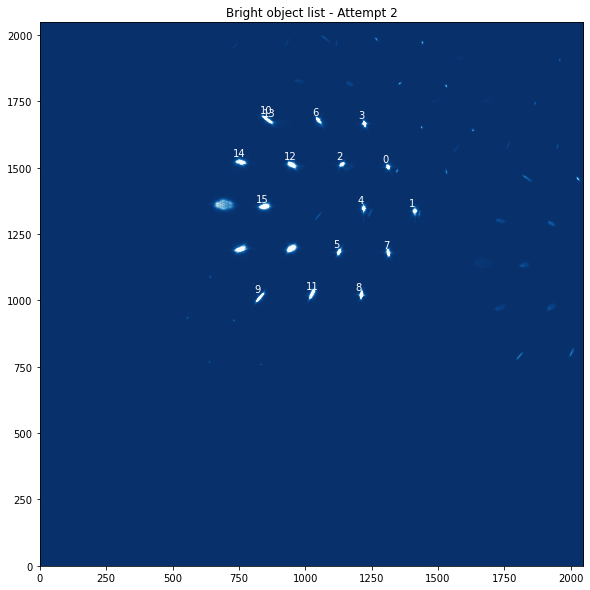

In [255]:
# Plot it
attempt2_loc = 'ote07_obs1_attempt2'

bobj_attempt2_filename = glob(os.path.join(data_location, attempt2_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
shifted_psuedo_fgs_filename = glob(os.path.join(data_location, attempt2_loc, 'guiding_config_1', 'FGS_imgs',
                                  'shifted*_config1.fits'))[0]
shifted_psuedo_fgs = fits.getdata(shifted_psuedo_fgs_filename)

plt.figure(figsize=(12, 10))
plt.imshow(shifted_psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
for i, (column, row) in enumerate(zip(bobj_attempt2['FPA Column (pixels)'].values, 
                                      bobj_attempt2['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')

plt.title('Bright object list - Attempt 2')
plt.show()

In [259]:
bobj_attempt2

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,27,1,1501,1310,15558,107355
1,1,24,2,1335,1411,14981,94553
2,2,27,2,1511,1136,12787,89717
3,3,30,1,1665,1221,10466,76790
4,4,24,1,1345,1218,13971,73177
5,5,21,1,1181,1125,9736,71339
6,6,30,1,1679,1046,8746,62228
7,7,21,2,1176,1312,7746,56053
8,8,18,2,1019,1209,5171,38296
9,9,18,1,1011,828,3452,26274


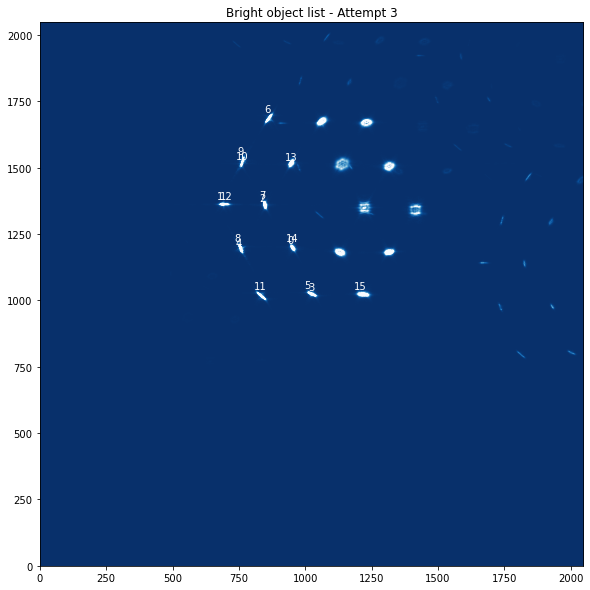

In [257]:
# Plot it
attempt3_loc = 'ote07_obs1_attempt3'

bobj_attempt3_filename = glob(os.path.join(data_location, attempt3_loc, 'guiding_config_1', 'dhas_shifted',
                                  'idSim*.bobj'))[0]
shifted_psuedo_fgs_filename = glob(os.path.join(data_location, attempt3_loc, 'guiding_config_1', 'FGS_imgs',
                                  'shifted*_config1.fits'))[0]
shifted_psuedo_fgs = fits.getdata(shifted_psuedo_fgs_filename)

plt.figure(figsize=(12, 10))
plt.imshow(shifted_psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
for i, (column, row) in enumerate(zip(bobj_attempt3['FPA Column (pixels)'].values, 
                                      bobj_attempt3['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')

plt.title('Bright object list - Attempt 3')
plt.show()

Once the user has the data (full frame NIRCam and FGS data and the guider products) they will need to run the ID strips from the failed run (for each config to be complete) in the DHAS to get the bright object list for that attempt. This will then be injested into this notebook and compared with the commanded value. When you do this, there are two options for what will happen: 
1. some/all of the the objects selected did not make it on the bright object list
2. or all selected objects made the bright object list but for some reason the FSW could not identify the ones selected 

Failure occurs when the gs and? at least 1 reference star does not make the bright object list

To fix this, you can see if increasing the threshold 

There are decently large descrepacies between what magic is measuring (and commanding) and what the FSW measures. It would be nice (and challenging) to compare the commanded values to measured values for all object, regardless of if they are part of a config. 